# Minimal Q-Learning in a 5×5 GridWorld (4 actions)



In [19]:
# Import Required Libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Constants and Hyperparameters
N_ROWS, N_COLS = 25, 25
START = (0, 0)
GOAL = (24, 24)
WALLS = [
    (2, 2), (3, 4), (5, 1), (7, 3), (4, 6), (8, 2), (6, 7),
    (2, 15), (4, 18), (6, 12), (8, 20), (3, 22), (7, 16), (9, 14),
    (15, 2), (18, 5), (20, 1), (16, 7), (22, 4), (19, 8), (17, 3),
    (15, 18), (17, 21), (19, 16), (21, 19), (18, 23), (16, 15), (20, 17),
    (10, 10), (12, 8), (14, 12), (11, 15), (13, 6), (9, 18), (15, 9),
    (5, 11), (8, 16), (11, 3), (14, 20), (17, 6), (20, 13), (23, 8),
    (1, 9), (4, 14), (7, 19), (10, 22), (13, 17), (16, 11), (19, 2),
    (22, 15), (6, 5), (9, 8), (12, 18), (15, 4), (18, 14), (21, 7),
    (1, 23), (23, 1), (3, 0), (0, 3), (24, 21), (21, 24)
]
STEP_REWARD = -0.1
BUMP_REWARD = -0.1
GOAL_REWARD = 1.0
GAMMA = 0.95
ALPHA = 0.5
EPISODES = 600
EPS_START, EPS_END, EPS_DECAY_EPISODES = 1.0, 0.05, 300
MAX_STEPS = 200
SEED = 123

In [20]:
class GridWorld:
    def __init__(self, n_rows, n_cols, start, goal, walls, step_reward, goal_reward, gamma):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.start = start
        self.goal = goal
        self.walls = set(walls)
        self.step_reward = step_reward
        self.goal_reward = goal_reward
        self.gamma = gamma

    def in_bounds(self, state):
        r, c = state
        return 0 <= r < self.n_rows and 0 <= c < self.n_cols

    def step(self, state, action, actions):
        if state == self.goal:
            return state, 0.0, True
        dr, dc = actions[action]
        next_state = (state[0] + dr, state[1] + dc)
        if not self.in_bounds(next_state) or next_state in self.walls:
            next_state = state  # Stay put if invalid
        reward = self.goal_reward if next_state == self.goal else self.step_reward
        done = next_state == self.goal
        return next_state, reward, done

    def to_index(self, state):
        r, c = state
        return r * self.n_cols + c

    def from_index(self, index):
        r = index // self.n_cols
        c = index % self.n_cols
        return (r, c)

# Initialize the GridWorld environment
grid_world = GridWorld(
    n_rows=25,
    n_cols=25,
    start=(0, 0),
    goal=(24, 24),
    walls = WALLS,
    step_reward=-0.1,
    goal_reward=1.0,
    gamma=0.95
)

All required functions:

In [21]:
# Action definitions
ACTIONS_4 = {
    0: (-1, 0),  # Up
    1: ( 1, 0),  # Down
    2: ( 0,-1),  # Left
    3: ( 0, 1),  # Right
}

ACTIONS_5 = dict(ACTIONS_4)
ACTIONS_5[4] = (1, 1)  # south-east (down-right)

# Utility functions
def epsilon_greedy(q_row, epsilon, rng):
    """Epsilon-greedy action selection"""
    if rng.random() < epsilon:
        return int(rng.integers(len(q_row)))
    # break ties randomly among maxima
    max_q = np.max(q_row)
    best = np.flatnonzero(q_row == max_q)
    return int(rng.choice(best))

def moving_average(x, w=20):
    """Calculate moving average"""
    if len(x) < w:
        return x.copy()
    return np.convolve(x, np.ones(w)/w, mode='valid')

# Legacy function wrappers for compatibility
def to_index(s):
    return grid_world.to_index(s)

def from_index(i):
    return grid_world.from_index(i)

def step(s, a, actions):
    return grid_world.step(s, a, actions)

More functions for visualisation:

In [22]:
class Visualizer:
    ARROWS = {0: '↑', 1: '↓', 2: '←', 3: '→', 4: '↘'}

    @staticmethod
    def derive_policy(Q, n_rows, n_cols):
        return np.argmax(Q, axis=1).reshape(n_rows, n_cols)

    @staticmethod
    def render_policy(policy, n_rows, n_cols, walls, start, goal):
        grid = []
        for r in range(n_rows):
            row = []
            for c in range(n_cols):
                s = (r, c)
                if s in walls:
                    row.append('■')
                elif s == goal:
                    row.append('G')
                elif s == start:
                    row.append('S')
                else:
                    row.append(Visualizer.ARROWS[int(policy[r, c])])
            grid.append(' '.join(row))
        print('\nOptimal policy (arrows), S=start, G=goal, ■=wall')
        print('\n'.join(grid))

    @staticmethod
    def print_value_grid(Q, n_rows, n_cols):
        V = np.max(Q, axis=1).reshape(n_rows, n_cols)
        with np.printoptions(precision=2, suppress=True):
            print('\nState-value grid V(s)=max_a Q(s,a):')
            print(V)

    @staticmethod
    def plot_results(returns, bumps, ma_window, label_prefix):
        ret_ma = np.convolve(returns, np.ones(ma_window)/ma_window, mode='valid')
        bumps_ma = np.convolve(bumps, np.ones(ma_window)/ma_window, mode='valid')

        plt.figure(figsize=(7.5, 4.2))
        plt.plot(np.arange(len(returns))[-len(ret_ma):], ret_ma, label=f'Return: {label_prefix}')
        plt.xlabel('Episode')
        plt.ylabel('Discounted return')
        plt.title('Q-learning in GridWorld')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(7.5, 4.2))
        plt.plot(bumps_ma, label=f'Total bumps: {label_prefix}')
        plt.xlabel('Episode')
        plt.ylabel('Total Bumps')
        plt.title('Q-learning in GridWorld')
        plt.legend()
        plt.tight_layout()
        plt.show()

## **1. Q learning with 4 actions:**

In [23]:
# Q-learning with 4 actions using refactored approach
rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)

NUM_STATES = N_ROWS * N_COLS
NUM_ACTIONS_4 = 4
Q4 = np.zeros((NUM_STATES, NUM_ACTIONS_4), dtype=float)

returns = np.zeros(EPISODES, dtype=float)
bumps = np.zeros(EPISODES, dtype=float)
steps_arr = np.zeros(EPISODES, dtype=int)

eps = EPS_START
eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)

for ep in range(EPISODES):
    s = START
    si = grid_world.to_index(s)
    done = False
    G = 0.0
    bumpcount = 0
    disc = 1.0
    steps = 0

    for t in range(MAX_STEPS):
        a = epsilon_greedy(Q4[si], eps, rng)
        s_next, r, done = grid_world.step(s, a, ACTIONS_4)
        s_next_i = grid_world.to_index(s_next)

        if si == s_next_i:
            bumpcount += 1
            r = BUMP_REWARD

        target = r if done else r + GAMMA * np.max(Q4[s_next_i])
        Q4[si, a] += ALPHA * (target - Q4[si, a])

        G += r
        disc *= GAMMA
        s, si = s_next, s_next_i
        steps += 1
        if done:
            break

    returns[ep] = G
    bumps[ep] = bumpcount
    steps_arr[ep] = steps
    if ep < EPS_DECAY_EPISODES:
        eps = max(EPS_END, eps - eps_decay)

print('Training (4 actions) complete!')
returns4 = returns.copy()
bumps4 = bumps.copy()
ma_w = 25
ret_ma4 = moving_average(returns4, w=ma_w)

policy4 = Visualizer.derive_policy(Q4, N_ROWS, N_COLS)
Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(Q4, N_ROWS, N_COLS)

Training (4 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↓ ↓ ■ ↑ → ↓ ↑ → → ↓ → ↑ ↓ → ↑ ← ↓ ↓ ← → → ↓ ↑ →
↑ ↓ → ↓ → → → ↓ ↑ ■ ↓ ↑ ↓ → ↑ ↓ ↓ ↑ ← ↓ → ↓ ↓ ■ ↓
→ → ■ → → → ← ↓ ↓ ↑ → ↑ → → → ■ ← → ↑ → ↓ ← ↑ ↑ →
■ ↑ ← ↑ ■ ← ← → → → → ↓ ↑ → ↑ → → ↓ → ↓ → ↓ ■ ↓ ↑
↑ ← → → ↑ → ■ ↓ → → → ↓ ↓ ← ■ ↓ ↑ → ■ ← → ↓ ← ↑ ↑
↑ ■ ← → ↓ → → ← → ↓ ↓ ■ ↓ → ↑ ← ← → → ↓ → ↓ ↓ ↓ ↓
↓ ↓ ← ↓ → ■ ↑ ■ ↓ ↑ → → ■ → ↓ ↓ ← ← → → → ↓ → ↓ ↓
← ↓ ↓ ■ → ↑ ↑ ↓ ↓ → → ↓ ← ← ← ↑ ■ ↓ ↓ ■ → ↓ ↓ → ↓
↓ ↓ ■ ↑ ↑ ↓ → ↓ ↓ → ↓ ↓ → ↑ ↑ ↓ ■ → → ↓ ■ ↓ ← ↓ ↓
↓ ↓ ← ↑ ↓ ↓ ↓ → ■ ↓ ↓ ↓ ↓ ↓ ■ → ↓ ↓ ■ → → ↓ ← ↓ ↓
→ → ↓ → ↓ → → ↓ → ↓ ■ ← ↑ ↓ ↓ → ↓ → → → → ↓ ■ ↓ ←
→ ↑ ← ■ → → ↓ → ↑ → → ↓ ↓ ↓ ↓ ■ ↓ → → ↓ → ↓ ↓ ← ↓
↓ ↓ ↓ ↓ ← → ↑ ↓ ■ ← ↓ ↓ → ↓ → ↓ ↓ ↑ ■ → → ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ → ↑ ■ ↓ ← ← → → → → → ↓ ↓ ■ ↓ → → → ↓ ← ←
← ↓ → ↓ ↑ → → ↓ ↓ → ↓ ↓ ■ ↓ ↓ → ↓ ↓ ← ↑ ■ ↓ ↓ ← →
← → ■ ↓ ■ ↓ ↓ → ↓ ■ → → → ↓ → → → ↓ ■ ↓ ↓ ↓ ↓ ← ↓
↓ ← ↑ ↑ ↑ ↑ ↓ ■ → ↓ ↓ ■ ↓ → ↓ ■ ↓ ↓ ↑ ↓ ↓ → ↓ ← ↓
→ ↑ ← ■ ↓ ↓ ■ ↑ → → → → → → → → → ↓ → ↓ ↓ ■ ↓ ← ↓
→ ↑ ← ↑ ↓ ■ ← ← → ↓

## Add a 5th action: South‑East diagonal


In [24]:
# Demo: take one south-east step from (3,2) using the new action map
s_demo = (3, 2)
s_next_demo, r_demo, done_demo = grid_world.step(s_demo, 4, ACTIONS_5)
print('From', s_demo, 'SE ->', s_next_demo, '| reward=', r_demo, '| done=', done_demo)
Visualizer.render_policy(policy4, N_ROWS, N_COLS, WALLS, START, GOAL)

From (3, 2) SE -> (4, 3) | reward= -0.1 | done= False

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↓ ↓ ■ ↑ → ↓ ↑ → → ↓ → ↑ ↓ → ↑ ← ↓ ↓ ← → → ↓ ↑ →
↑ ↓ → ↓ → → → ↓ ↑ ■ ↓ ↑ ↓ → ↑ ↓ ↓ ↑ ← ↓ → ↓ ↓ ■ ↓
→ → ■ → → → ← ↓ ↓ ↑ → ↑ → → → ■ ← → ↑ → ↓ ← ↑ ↑ →
■ ↑ ← ↑ ■ ← ← → → → → ↓ ↑ → ↑ → → ↓ → ↓ → ↓ ■ ↓ ↑
↑ ← → → ↑ → ■ ↓ → → → ↓ ↓ ← ■ ↓ ↑ → ■ ← → ↓ ← ↑ ↑
↑ ■ ← → ↓ → → ← → ↓ ↓ ■ ↓ → ↑ ← ← → → ↓ → ↓ ↓ ↓ ↓
↓ ↓ ← ↓ → ■ ↑ ■ ↓ ↑ → → ■ → ↓ ↓ ← ← → → → ↓ → ↓ ↓
← ↓ ↓ ■ → ↑ ↑ ↓ ↓ → → ↓ ← ← ← ↑ ■ ↓ ↓ ■ → ↓ ↓ → ↓
↓ ↓ ■ ↑ ↑ ↓ → ↓ ↓ → ↓ ↓ → ↑ ↑ ↓ ■ → → ↓ ■ ↓ ← ↓ ↓
↓ ↓ ← ↑ ↓ ↓ ↓ → ■ ↓ ↓ ↓ ↓ ↓ ■ → ↓ ↓ ■ → → ↓ ← ↓ ↓
→ → ↓ → ↓ → → ↓ → ↓ ■ ← ↑ ↓ ↓ → ↓ → → → → ↓ ■ ↓ ←
→ ↑ ← ■ → → ↓ → ↑ → → ↓ ↓ ↓ ↓ ■ ↓ → → ↓ → ↓ ↓ ← ↓
↓ ↓ ↓ ↓ ← → ↑ ↓ ■ ← ↓ ↓ → ↓ → ↓ ↓ ↑ ■ → → ↓ ↓ ↓ ↓
↓ ↓ ↓ ↓ → ↑ ■ ↓ ← ← → → → → → ↓ ↓ ■ ↓ → → → ↓ ← ←
← ↓ → ↓ ↑ → → ↓ ↓ → ↓ ↓ ■ ↓ ↓ → ↓ ↓ ← ↑ ■ ↓ ↓ ← →
← → ■ ↓ ■ ↓ ↓ → ↓ ■ → → → ↓ → → → ↓ ■ ↓ ↓ ↓ ↓ ← ↓
↓ ← ↑ ↑ ↑ ↑ ↓ ■ → ↓ ↓ ■ ↓ → ↓ ■ ↓ ↓ ↑ ↓ ↓ → ↓ ← ↓
→ ↑ ← ■ ↓ ↓ ■ ↑ → → → → → → → → → ↓ → ↓ ↓ ■ ↓ 

## **2. Plain Q learning with 5 actions:**

In [25]:
class QLearningAgent:
    def __init__(self, grid_world, n_actions, episodes=600, alpha=0.5, 
                 eps_start=1.0, eps_end=0.05, eps_decay_episodes=300, 
                 max_steps=200, seed=123):
        self.grid_world = grid_world
        self.n_actions = n_actions
        self.episodes = episodes
        self.alpha = alpha
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_episodes = eps_decay_episodes
        self.max_steps = max_steps
        self.seed = seed
        
        # Initialize random number generators
        self.rng = np.random.default_rng(seed)
        random.seed(seed)
        np.random.seed(seed)
        
        # Initialize Q-table and tracking arrays
        self.num_states = grid_world.n_rows * grid_world.n_cols
        self.Q = np.zeros((self.num_states, n_actions), dtype=float)
        self.returns = np.zeros(episodes, dtype=float)
        self.bumps = np.zeros(episodes, dtype=float)
        self.steps_arr = np.zeros(episodes, dtype=int)
        
        # Epsilon decay calculation
        self.eps_decay = (eps_start - eps_end) / max(1, eps_decay_episodes)
    
    def train(self, actions_dict, epsilon_greedy_func, bump_reward):
        """Train the Q-learning agent"""
        eps = self.eps_start
        
        for ep in range(self.episodes):
            s = self.grid_world.start
            si = self.grid_world.to_index(s)
            done = False
            G = 0.0
            bumpcount = 0
            disc = 1.0
            steps = 0

            for t in range(self.max_steps):
                a = epsilon_greedy_func(self.Q[si], eps, self.rng)
                s_next, r, done = self.grid_world.step(s, a, actions_dict)
                s_next_i = self.grid_world.to_index(s_next)

                if si == s_next_i:
                    bumpcount += 1
                    r = bump_reward

                target = r if done else r + self.grid_world.gamma * np.max(self.Q[s_next_i])
                self.Q[si, a] += self.alpha * (target - self.Q[si, a])

                G += r
                disc *= self.grid_world.gamma
                s, si = s_next, s_next_i
                steps += 1
                if done:
                    break

            self.returns[ep] = G
            self.bumps[ep] = bumpcount
            self.steps_arr[ep] = steps
            
            if ep < self.eps_decay_episodes:
                eps = max(self.eps_end, eps - self.eps_decay)
        
        print(f'Training ({self.n_actions} actions) complete!')
    
    def get_policy(self, n_rows, n_cols):
        """Get the derived policy from Q-table"""
        return Visualizer.derive_policy(self.Q, n_rows, n_cols)
    
    def get_results(self, moving_average_func, ma_window=25):
        """Get training results with moving averages"""
        return {
            'returns': self.returns.copy(),
            'Q': self.Q.copy(),
            'bumps': self.bumps.copy(),
            'returns_ma': moving_average_func(self.returns, w=ma_window),
            'steps_ma': moving_average_func(self.steps_arr.astype(float), w=ma_window)
        }

# Usage example for plain Q-learning with 5 actions:
agent = QLearningAgent(grid_world, 5, seed=SEED)
agent.train(ACTIONS_5, epsilon_greedy, BUMP_REWARD)

policy5plain = agent.get_policy(N_ROWS, N_COLS)
Visualizer.render_policy(policy5plain, N_ROWS, N_COLS, WALLS, START, GOAL)
Visualizer.print_value_grid(agent.Q, N_ROWS, N_COLS)

results = agent.get_results(moving_average)
returns5plain = results['returns']
Q5plain = results['Q']
bumps5plain = results['bumps']
ret_ma5plain = results['returns_ma']
steps_m5plain = results['steps_ma']

Training (5 actions) complete!

Optimal policy (arrows), S=start, G=goal, ■=wall
S ↘ → ■ ↑ → ↘ ↑ ↓ ↘ → ↓ ↑ ↘ ↑ ↑ ← → ↑ ↑ → ↘ ↘ ↑ ←
↘ ↓ → → ↑ ↘ ↘ ↘ ↑ ■ → ↑ ↘ → ↑ → → ↘ → → ↑ ↑ ↓ ■ ←
↓ ← ■ → ↘ ↘ → ↘ ↑ ↑ ↑ ↑ → ↓ ↑ ■ ← → ← ↘ ↑ ↘ ↘ ↓ ↘
■ ↓ ← ↘ ■ → → ↑ ↘ → ↘ ↘ ↓ → → ↘ ↓ ↓ → ↑ ↘ ↑ ■ ← ↘
↘ ← ↓ ↘ ↘ ← ■ ↓ ↑ ↘ ↘ ↘ ↓ ← ■ ↘ ↓ ← ■ ↓ ↑ ← ↑ ↑ →
→ ■ ↓ ↓ → ↘ ↓ ↘ ↑ ↓ → ■ → ↘ → → ← → → ← ↑ ↑ → ↑ ↓
→ ← ↓ ← ↘ ■ → ■ → ↘ ↓ ↘ ■ ↘ ↑ ← → ↓ ↑ → ↓ → ← ↑ →
↓ ← ↘ ■ ↘ ↘ ↓ → ↘ ↘ → ↓ → → ↘ ↓ ■ → ← ■ → ↓ ← → ↑
↓ → ■ ↘ ↑ ↘ ↘ ↓ ↘ ↘ ↓ ↓ ↘ ↓ ↘ ↘ ■ ↓ → ↘ ■ ↓ ↘ ↘ ↘
↓ → ↘ ↑ ↘ ↘ ↘ ↘ ■ → ↘ ↘ ↓ ↓ ■ → ↘ → ■ ↘ ↘ ↓ → ↘ ↓
← ← ↓ ↓ ↑ ↘ ↘ ↘ ↑ ↘ ■ ↓ ↓ ↘ ↓ ← ↘ ↘ ↓ ↓ ↓ ↓ ■ ↓ ↓
← ↘ ↘ ■ → ↓ ↑ → ↘ ↘ → ↘ ↓ ↘ ↓ ■ ↘ ↘ ↘ ↓ ↓ ↘ ↓ ↓ ←
↘ → ↓ ↓ ← ← ↑ ↘ ■ ↘ → ↘ ↘ ↘ ↓ ↘ ↓ ↘ ■ ↘ ↓ ↘ ↓ ↓ ↘
← ← ↑ ← ← ↑ ■ ↘ → → ↘ ↓ ↘ ↘ ↓ → ↓ ■ ↘ → ↘ ↘ ↓ ← ←
← ↑ → → ↑ ↘ → ← → → → ↘ ■ ↓ ↘ ↓ ↘ ↓ ↘ ↘ ■ ↘ ↓ ← ↓
↓ ↓ ■ ↑ ■ → ↓ → ↘ ■ → → → ↘ ↓ ↘ ↓ ↘ ■ ↓ ↘ ↘ ↓ ← ←
↑ ↓ ↓ ← ↑ ← ← ■ ↓ ↘ ↘ ■ ↘ ↘ ↘ ■ ↘ ↘ ↘ ↘ ↓ ↘ ↓ ← ←
↘ → ← ■ → ← ■ → ↘ ↘ → → → → ↘ ↘ ↘ ↘ ↓ ↓ ↘ ■ ↓ ← ↓
↑ → ↓ ↑ ↘ ■ ↑ → ↑ ↘

## **3. Q learning with 5 actions and an oracle model**

In [26]:
def oracle_model(s):
    """Oracle model that predicts the next state for action 4 (south-east)"""
    s_model_next, r_model, done_model = grid_world.step(grid_world.from_index(s), 4, ACTIONS_5)
    return s_model_next

Running multiple experiments for statistical analysis...
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 actions) complete!
Training (5 actions) complete!
Training (4 a

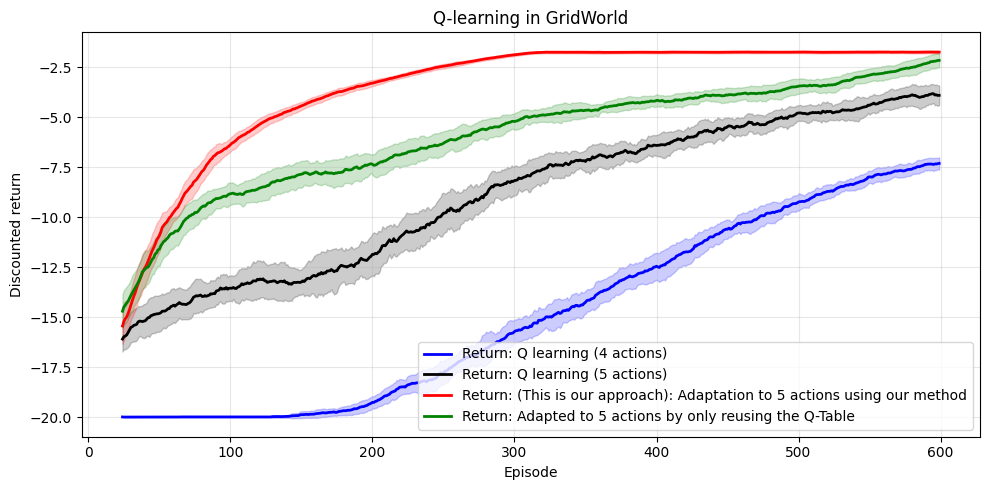

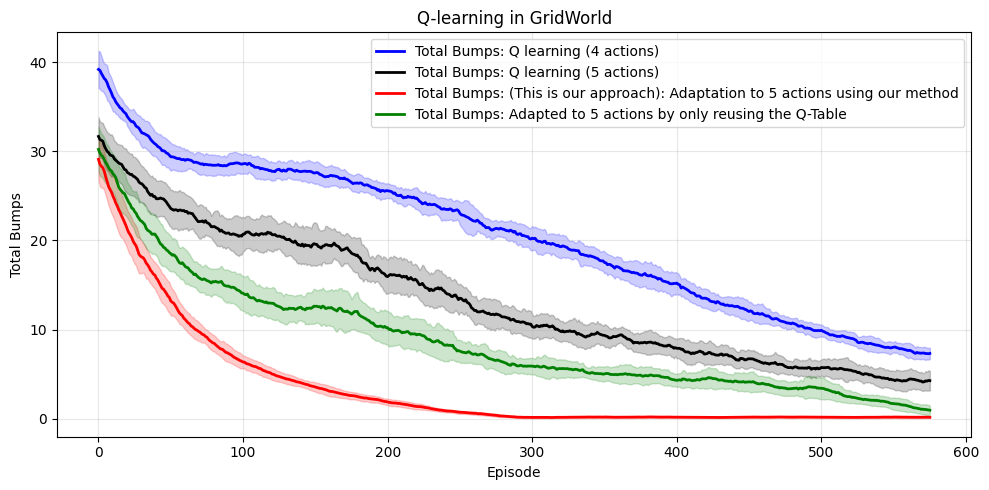

In [27]:
class OracleQLearningAgent(QLearningAgent):
    """Q-learning agent with oracle model for action adaptation"""
    
    def __init__(self, grid_world, n_actions, base_q_table=None, episodes=600, alpha=0.5, 
                 eps_start=1.0, eps_end=0.05, eps_decay_episodes=300, 
                 max_steps=200, seed=123, use_model = True):
        super().__init__(grid_world, n_actions, episodes, alpha, eps_start, eps_end, 
                        eps_decay_episodes, max_steps, seed)
        self.reuse_count = np.zeros(self.episodes, dtype = float)
        self.use_model = use_model
        # Initialize with base Q-table if provided
        if base_q_table is not None:
            self.Q[:, :base_q_table.shape[1]] = base_q_table
            # Optimistic initialization for new actions
            if use_model == True:
                V_old = np.max(base_q_table, axis=1) 
                for new_action in range(base_q_table.shape[1], n_actions):
                    self.Q[:, new_action] = V_old
    
    def train_with_oracle(self, actions_dict, epsilon_greedy_func, bump_reward, oracle_func, base_q_table):
        """Train with oracle model guidance"""
        eps = self.eps_start
        for ep in range(self.episodes):
            s = self.grid_world.start
            si = self.grid_world.to_index(s)
            done = False
            G = 0.0
            bumpcount = 0
            disc = 1.0
            steps = 0
            reuse = 0
            for t in range(self.max_steps):
                a = epsilon_greedy_func(self.Q[si], eps, self.rng)
                # Oracle guidance for new action (action 4)
                if self.use_model is True:
                  if a == 4:
                    snext_model = oracle_func(si)
                    snext_model_i = self.grid_world.to_index(snext_model)
                    # Only accept if it leads to better state value
                    if np.max(self.Q[snext_model_i]) < np.max(self.Q[si]):
                        # Fall back to original action set
                        a = epsilon_greedy_func(base_q_table[si], eps, self.rng)
                    else: 
                        reuse += 1
                s_next, r, done = self.grid_world.step(s, a, actions_dict)
                s_next_i = self.grid_world.to_index(s_next)

                if si == s_next_i:
                    bumpcount += 1
                    r = bump_reward
                    

                target = r if done else r + self.grid_world.gamma * np.max(self.Q[s_next_i])
                self.Q[si, a] += self.alpha * (target - self.Q[si, a])

                G += r
                disc *= self.grid_world.gamma
                s, si = s_next, s_next_i
                steps += 1
                if done:
                    break
            self.reuse_count[ep] = reuse    
            self.returns[ep] = G
            self.bumps[ep] = bumpcount
            self.steps_arr[ep] = steps
            
            if ep < self.eps_decay_episodes:
                eps = max(self.eps_end, eps - self.eps_decay)

def run_multiple_experiments(n_runs=5, base_seed=123):
    """Run multiple experiments with different seeds and return statistics"""
    
    # Storage for all runs
    all_returns4 = []
    all_returns5plain = []
    all_returns5oracle = []
    all_returns5ignore = []
    all_bumps4 = []
    all_bumps5plain = []
    all_bumps5oracle = []
    all_bumps5ignore = []
    
    for run in range(n_runs):
        current_seed = base_seed + run * 42
        # Reset random seeds
        rng = np.random.default_rng(current_seed)
        random.seed(current_seed)
        np.random.seed(current_seed)
        
        # 1. Q-learning with 4 actions
        agent_plain_4_action = QLearningAgent(grid_world, 4, seed=current_seed)
        agent_plain_4_action.train(ACTIONS_4, epsilon_greedy, BUMP_REWARD)
        results_plain = agent_plain_4_action.get_results(moving_average)
        all_returns4.append(results_plain['returns'])
        all_bumps4.append(results_plain['bumps'])
        
        # 2. Plain Q-learning with 5 actions
        agent_plain = QLearningAgent(grid_world, 5, seed=current_seed)
        agent_plain.train(ACTIONS_5, epsilon_greedy, BUMP_REWARD)
        results_plain = agent_plain.get_results(moving_average)
        all_returns5plain.append(results_plain['returns'])
        all_bumps5plain.append(results_plain['bumps'])
        
        # 3. Ignore model (only Q-table reuse)
        ignore_model_run = OracleQLearningAgent(grid_world, 5, base_q_table=agent_plain_4_action.Q, seed=current_seed, use_model=False)
        ignore_model_run.train_with_oracle(ACTIONS_5, epsilon_greedy, BUMP_REWARD, oracle_model, agent_plain_4_action.Q)
        ignore_model_result_run = ignore_model_run.get_results(moving_average)
        all_returns5ignore.append(ignore_model_result_run['returns'])
        all_bumps5ignore.append(ignore_model_result_run['bumps'])
        
        # 4. Oracle Q-learning with 5 actions
        oracle_agent_run = OracleQLearningAgent(grid_world, 5, base_q_table=agent_plain_4_action.Q, seed=current_seed)
        oracle_agent_run.train_with_oracle(ACTIONS_5, epsilon_greedy, BUMP_REWARD, oracle_model, agent_plain_4_action.Q)
        oracle_results_run = oracle_agent_run.get_results(moving_average)
        all_returns5oracle.append(oracle_results_run['returns'])
        all_bumps5oracle.append(oracle_results_run['bumps'])
    
    # Calculate statistics
    all_returns4 = np.array(all_returns4)
    all_returns5plain = np.array(all_returns5plain)
    all_returns5oracle = np.array(all_returns5oracle)
    all_returns5ignore = np.array(all_returns5ignore)
    all_bumps4 = np.array(all_bumps4)
    all_bumps5plain = np.array(all_bumps5plain)
    all_bumps5oracle = np.array(all_bumps5oracle)
    all_bumps5ignore = np.array(all_bumps5ignore)
    
    # Calculate moving averages for all runs
    ma_w = 25
    all_ret_ma4 = np.array([moving_average(returns, w=ma_w) for returns in all_returns4])
    all_ret_ma5plain = np.array([moving_average(returns, w=ma_w) for returns in all_returns5plain])
    all_ret_ma5oracle = np.array([moving_average(returns, w=ma_w) for returns in all_returns5oracle])
    all_ret_ma5ignore = np.array([moving_average(returns, w=ma_w) for returns in all_returns5ignore])
    
    all_bumps4_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps4])
    all_bumps5plain_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5plain])
    all_bumps5oracle_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5oracle])
    all_bumps5ignore_avg = np.array([moving_average(bumps, w=ma_w) for bumps in all_bumps5ignore])
    
    return {
        'returns': {
            '4_actions': {'mean': np.mean(all_ret_ma4, axis=0), 'std': np.std(all_ret_ma4, axis=0)},
            '5_plain': {'mean': np.mean(all_ret_ma5plain, axis=0), 'std': np.std(all_ret_ma5plain, axis=0)},
            '5_oracle': {'mean': np.mean(all_ret_ma5oracle, axis=0), 'std': np.std(all_ret_ma5oracle, axis=0)},
            '5_ignore': {'mean': np.mean(all_ret_ma5ignore, axis=0), 'std': np.std(all_ret_ma5ignore, axis=0)}
        },
        'bumps': {
            '4_actions': {'mean': np.mean(all_bumps4_avg, axis=0), 'std': np.std(all_bumps4_avg, axis=0)},
            '5_plain': {'mean': np.mean(all_bumps5plain_avg, axis=0), 'std': np.std(all_bumps5plain_avg, axis=0)},
            '5_oracle': {'mean': np.mean(all_bumps5oracle_avg, axis=0), 'std': np.std(all_bumps5oracle_avg, axis=0)},
            '5_ignore': {'mean': np.mean(all_bumps5ignore_avg, axis=0), 'std': np.std(all_bumps5ignore_avg, axis=0)}
        }
    }

# Run multiple experiments
print("Running multiple experiments for statistical analysis...")
stats = run_multiple_experiments(n_runs=30)

# Plot results with shaded error bars
def plot_with_shaded_errors(stats, figsize=(10, 5)):
    """Plot results with shaded error bars"""
    
    # Returns plot
    plt.figure(figsize=figsize)
    
    # Calculate x-axis for each series (they might have different lengths due to moving average)
    episodes_total = EPISODES
    ma_w = 25
    
    # Plot each method with shaded error bars
    methods = [
        ('4_actions', 'Q learning (4 actions)', 'blue'),
        ('5_plain', 'Q learning (5 actions)', 'black'), 
        ('5_oracle', '(This is our approach): Adaptation to 5 actions using our method', 'red'),
        ('5_ignore', 'Adapted to 5 actions by only reusing the Q-Table', 'green')
    ]
    
    for method_key, label, color in methods:
        mean_vals = stats['returns'][method_key]['mean']
        std_vals = stats['returns'][method_key]['std']
        x_vals = np.arange(episodes_total - len(mean_vals), episodes_total)
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Return: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Discounted return')
    plt.title('Q-learning in GridWorld')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Bumps plot
    plt.figure(figsize=figsize)
    
    for method_key, label, color in methods:
        mean_vals = stats['bumps'][method_key]['mean']
        std_vals = stats['bumps'][method_key]['std']
        x_vals = np.arange(len(mean_vals))
        
        # Plot mean line
        plt.plot(x_vals, mean_vals, color=color, label=f'Total Bumps: {label}', linewidth=2)
        
        # Plot shaded error region (mean ± std)
        plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                        color=color, alpha=0.2)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Bumps')
    plt.title('Q-learning in GridWorld')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the results with shaded error bars
plot_with_shaded_errors(stats)

In [28]:
import pandas as pd
import os
from datetime import datetime

def save_results_to_csv(stats, output_dir="results"):
    """
    Save all experimental results to CSV files
    
    Args:
        stats: Dictionary containing statistical results from multiple runs
        output_dir: Directory to save CSV files
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create timestamp for file naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Save Returns Data (Mean and Std)
    returns_data = []
    episodes_total = EPISODES
    ma_w = 25
    
    for method_key in ['4_actions', '5_plain', '5_oracle', '5_ignore']:
        mean_vals = stats['returns'][method_key]['mean']
        std_vals = stats['returns'][method_key]['std']
        x_vals = np.arange(episodes_total - len(mean_vals), episodes_total)
        
        method_names = {
            '4_actions': 'Q_learning_4_actions',
            '5_plain': 'Q_learning_5_actions',
            '5_oracle': 'Oracle_method_5_actions',
            '5_ignore': 'Q_table_reuse_5_actions'
        }
        
        for i, (episode, mean_val, std_val) in enumerate(zip(x_vals, mean_vals, std_vals)):
            returns_data.append({
                'Method': method_names[method_key],
                'Episode': episode,
                'Mean_Return': mean_val,
                'Std_Return': std_val,
                'Upper_Bound': mean_val + std_val,
                'Lower_Bound': mean_val - std_val
            })
    
    returns_df = pd.DataFrame(returns_data)
    returns_filename = f"{output_dir}/returns_data_{timestamp}.csv"
    returns_df.to_csv(returns_filename, index=False)
    print(f"Returns data saved to: {returns_filename}")
    
    # 2. Save Bumps Data (Mean and Std)
    bumps_data = []
    
    for method_key in ['4_actions', '5_plain', '5_oracle', '5_ignore']:
        mean_vals = stats['bumps'][method_key]['mean']
        std_vals = stats['bumps'][method_key]['std']
        x_vals = np.arange(len(mean_vals))
        
        method_names = {
            '4_actions': 'Q_learning_4_actions',
            '5_plain': 'Q_learning_5_actions',
            '5_oracle': 'Oracle_method_5_actions',
            '5_ignore': 'Q_table_reuse_5_actions'
        }
        
        for i, (episode, mean_val, std_val) in enumerate(zip(x_vals, mean_vals, std_vals)):
            bumps_data.append({
                'Method': method_names[method_key],
                'Episode': episode,
                'Mean_Bumps': mean_val,
                'Std_Bumps': std_val,
                'Upper_Bound': mean_val + std_val,
                'Lower_Bound': mean_val - std_val
            })
    
    bumps_df = pd.DataFrame(bumps_data)
    bumps_filename = f"{output_dir}/bumps_data_{timestamp}.csv"
    bumps_df.to_csv(bumps_filename, index=False)
    print(f"Bumps data saved to: {bumps_filename}")
    
    # 3. Save Summary Statistics
    summary_data = []
    
    for method_key in ['4_actions', '5_plain', '5_oracle', '5_ignore']:
        method_names = {
            '4_actions': 'Q_learning_4_actions',
            '5_plain': 'Q_learning_5_actions',
            '5_oracle': 'Oracle_method_5_actions',
            '5_ignore': 'Q_table_reuse_5_actions'
        }
        
        returns_mean = stats['returns'][method_key]['mean']
        returns_std = stats['returns'][method_key]['std']
        bumps_mean = stats['bumps'][method_key]['mean']
        bumps_std = stats['bumps'][method_key]['std']
        
        summary_data.append({
            'Method': method_names[method_key],
            'Final_Mean_Return': returns_mean[-1],
            'Final_Std_Return': returns_std[-1],
            'Final_Mean_Bumps': bumps_mean[-1],
            'Final_Std_Bumps': bumps_std[-1],
            'Best_Mean_Return': np.max(returns_mean),
            'Best_Return_Episode': np.argmax(returns_mean) + (EPISODES - len(returns_mean)),
            'Lowest_Mean_Bumps': np.min(bumps_mean),
            'Lowest_Bumps_Episode': np.argmin(bumps_mean),
            'Data_Points': len(returns_mean)
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_filename = f"{output_dir}/summary_statistics_{timestamp}.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"Summary statistics saved to: {summary_filename}")
    
    # 4. Save Experimental Configuration
    config_data = {
        'Parameter': ['N_ROWS', 'N_COLS', 'EPISODES', 'ALPHA', 'GAMMA', 'EPS_START', 'EPS_END', 
                     'EPS_DECAY_EPISODES', 'MAX_STEPS', 'STEP_REWARD', 'GOAL_REWARD', 'BUMP_REWARD',
                     'MOVING_AVERAGE_WINDOW', 'NUMBER_OF_RUNS', 'BASE_SEED'],
        'Value': [N_ROWS, N_COLS, EPISODES, ALPHA, GAMMA, EPS_START, EPS_END, 
                 EPS_DECAY_EPISODES, MAX_STEPS, STEP_REWARD, GOAL_REWARD, BUMP_REWARD,
                 ma_w, 5, 123]
    }
    
    config_df = pd.DataFrame(config_data)
    config_filename = f"{output_dir}/experimental_config_{timestamp}.csv"
    config_df.to_csv(config_filename, index=False)
    print(f"Experimental configuration saved to: {config_filename}")
    
    # 5. Create a metadata file
    metadata = {
        'Experiment_Name': 'Q_Learning_Action_Space_Adaptation',
        'Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'Description': 'Comparison of Q-learning with 4 actions vs 5 actions vs oracle-guided adaptation',
        'Methods': ['Q_learning_4_actions', 'Q_learning_5_actions', 'Oracle_method_5_actions', 'Q_table_reuse_5_actions'],
        'Files_Generated': [returns_filename, bumps_filename, summary_filename, config_filename],
        'Grid_Size': f"{N_ROWS}x{N_COLS}",
        'Total_Episodes': EPISODES,
        'Number_of_Runs': 5
    }
    
    metadata_df = pd.DataFrame(list(metadata.items()), columns=['Key', 'Value'])
    metadata_filename = f"{output_dir}/experiment_metadata_{timestamp}.csv"
    metadata_df.to_csv(metadata_filename, index=False)
    print(f"Experiment metadata saved to: {metadata_filename}")
    
    return {
        'returns_file': returns_filename,
        'bumps_file': bumps_filename,
        'summary_file': summary_filename,
        'config_file': config_filename,
        'metadata_file': metadata_filename
    }

# Save all results to CSV files
print("Saving experimental results to CSV files...")
saved_files = save_results_to_csv(stats)

# Display summary of saved files
print("\n" + "="*60)
print("EXPERIMENTAL RESULTS SAVED SUCCESSFULLY")
print("="*60)
for key, filename in saved_files.items():
    print(f"{key.replace('_', ' ').title()}: {filename}")
print("="*60)

Saving experimental results to CSV files...
Returns data saved to: results/returns_data_20250926_191546.csv
Bumps data saved to: results/bumps_data_20250926_191546.csv
Summary statistics saved to: results/summary_statistics_20250926_191546.csv
Experimental configuration saved to: results/experimental_config_20250926_191546.csv
Experiment metadata saved to: results/experiment_metadata_20250926_191546.csv

EXPERIMENTAL RESULTS SAVED SUCCESSFULLY
Returns File: results/returns_data_20250926_191546.csv
Bumps File: results/bumps_data_20250926_191546.csv
Summary File: results/summary_statistics_20250926_191546.csv
Config File: results/experimental_config_20250926_191546.csv
Metadata File: results/experiment_metadata_20250926_191546.csv


In [10]:
def save_raw_run_data_to_csv(output_dir="results", n_runs=30, base_seed=123):
    """
    Save individual run data (not aggregated) to CSV files for detailed analysis
    This function re-runs the experiments to capture individual run data
    """
    print("Generating and saving individual run data...")
    
    # Create timestamp for file naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Storage for individual run data
    individual_returns_data = []
    individual_bumps_data = []
    
    for run in range(n_runs):
        current_seed = base_seed + run * 42
        print(f"Processing run {run + 1}/{n_runs} for CSV export...")
        
        # Reset random seeds
        rng = np.random.default_rng(current_seed)
        random.seed(current_seed)
        np.random.seed(current_seed)
        
        # 1. Q-learning with 4 actions
        NUM_STATES = N_ROWS * N_COLS
        NUM_ACTIONS_4 = 4
        Q4_run = np.zeros((NUM_STATES, NUM_ACTIONS_4), dtype=float)
        returns_run = np.zeros(EPISODES, dtype=float)
        bumps_run = np.zeros(EPISODES, dtype=float)
        
        eps = EPS_START
        eps_decay = (EPS_START - EPS_END) / max(1, EPS_DECAY_EPISODES)
        
        for ep in range(EPISODES):
            s = START
            si = grid_world.to_index(s)
            done = False
            G = 0.0
            bumpcount = 0
            
            for t in range(MAX_STEPS):
                a = epsilon_greedy(Q4_run[si], eps, rng)
                s_next, r, done = grid_world.step(s, a, ACTIONS_4)
                s_next_i = grid_world.to_index(s_next)

                if si == s_next_i:
                    bumpcount += 1
                    r = BUMP_REWARD

                target = r if done else r + GAMMA * np.max(Q4_run[s_next_i])
                Q4_run[si, a] += ALPHA * (target - Q4_run[si, a])

                G += r
                s, si = s_next, s_next_i
                if done:
                    break

            returns_run[ep] = G
            bumps_run[ep] = bumpcount
            if ep < EPS_DECAY_EPISODES:
                eps = max(EPS_END, eps - eps_decay)
        
        # Save 4-action data
        for ep in range(EPISODES):
            individual_returns_data.append({
                'Method': 'Q_learning_4_actions',
                'Run': run + 1,
                'Seed': current_seed,
                'Episode': ep,
                'Return': returns_run[ep]
            })
            individual_bumps_data.append({
                'Method': 'Q_learning_4_actions',
                'Run': run + 1,
                'Seed': current_seed,
                'Episode': ep,
                'Bumps': bumps_run[ep]
            })
        
        # 2. Plain Q-learning with 5 actions
        agent_plain = QLearningAgent(grid_world, 5, seed=current_seed)
        agent_plain.train(ACTIONS_5, epsilon_greedy, BUMP_REWARD)
        results_plain = agent_plain.get_results(moving_average)
        
        for ep in range(EPISODES):
            individual_returns_data.append({
                'Method': 'Q_learning_5_actions',
                'Run': run + 1,
                'Seed': current_seed,
                'Episode': ep,
                'Return': results_plain['returns'][ep]
            })
            individual_bumps_data.append({
                'Method': 'Q_learning_5_actions',
                'Run': run + 1,
                'Seed': current_seed,
                'Episode': ep,
                'Bumps': results_plain['bumps'][ep]
            })
        
        # 3. Oracle Q-learning with 5 actions
        oracle_agent_run = OracleQLearningAgent(grid_world, 5, base_q_table=Q4_run, seed=current_seed)
        oracle_agent_run.train_with_oracle(ACTIONS_5, epsilon_greedy, BUMP_REWARD, oracle_model, Q4_run)
        oracle_results_run = oracle_agent_run.get_results(moving_average)
        
        for ep in range(EPISODES):
            individual_returns_data.append({
                'Method': 'Oracle_method_5_actions',
                'Run': run + 1,
                'Seed': current_seed,
                'Episode': ep,
                'Return': oracle_results_run['returns'][ep]
            })
            individual_bumps_data.append({
                'Method': 'Oracle_method_5_actions',
                'Run': run + 1,
                'Seed': current_seed,
                'Episode': ep,
                'Bumps': oracle_results_run['bumps'][ep]
            })
        
        # 4. Ignore model (only Q-table reuse)
        ignore_model_run = OracleQLearningAgent(grid_world, 5, base_q_table=Q4_run, seed=current_seed, use_model=False)
        ignore_model_run.train_with_oracle(ACTIONS_5, epsilon_greedy, BUMP_REWARD, oracle_model, Q4_run)
        ignore_model_result_run = ignore_model_run.get_results(moving_average)
        
        for ep in range(EPISODES):
            individual_returns_data.append({
                'Method': 'Q_table_reuse_5_actions',
                'Run': run + 1,
                'Seed': current_seed,
                'Episode': ep,
                'Return': ignore_model_result_run['returns'][ep]
            })
            individual_bumps_data.append({
                'Method': 'Q_table_reuse_5_actions',
                'Run': run + 1,
                'Seed': current_seed,
                'Episode': ep,
                'Bumps': ignore_model_result_run['bumps'][ep]
            })
    
    # Save individual run data
    individual_returns_df = pd.DataFrame(individual_returns_data)
    individual_bumps_df = pd.DataFrame(individual_bumps_data)
    
    individual_returns_filename = f"{output_dir}/individual_returns_data_{timestamp}.csv"
    individual_bumps_filename = f"{output_dir}/individual_bumps_data_{timestamp}.csv"
    
    individual_returns_df.to_csv(individual_returns_filename, index=False)
    individual_bumps_df.to_csv(individual_bumps_filename, index=False)
    
    print(f"Individual returns data saved to: {individual_returns_filename}")
    print(f"Individual bumps data saved to: {individual_bumps_filename}")
    
    return {
        'individual_returns_file': individual_returns_filename,
        'individual_bumps_file': individual_bumps_filename
    }

Found latest timestamp: 20250926_191546
Found 5 files with timestamp 20250926_191546
Loaded returns data: returns_data_20250926_191546.csv
Loaded bumps data: bumps_data_20250926_191546.csv
Loaded summary data: summary_statistics_20250926_191546.csv
Loaded config data: experimental_config_20250926_191546.csv
Loaded metadata: experiment_metadata_20250926_191546.csv
Successfully loaded 5 datasets


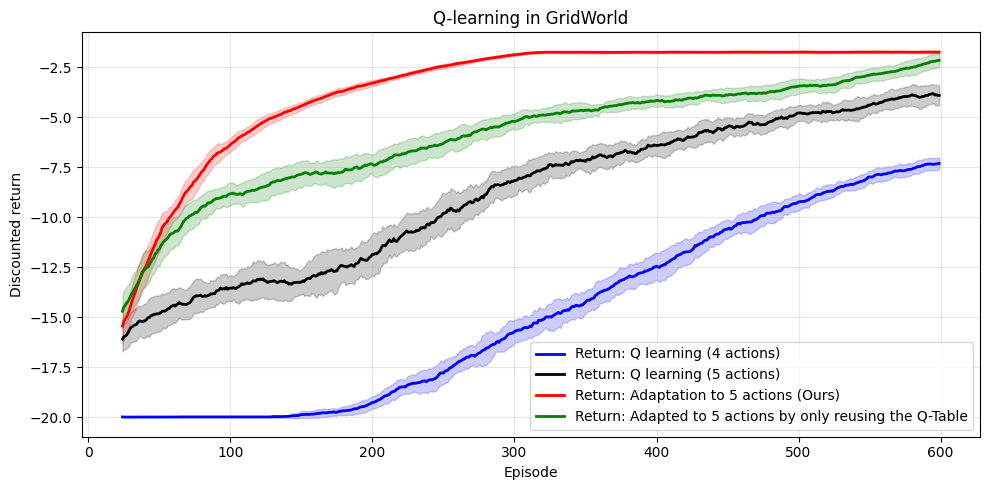

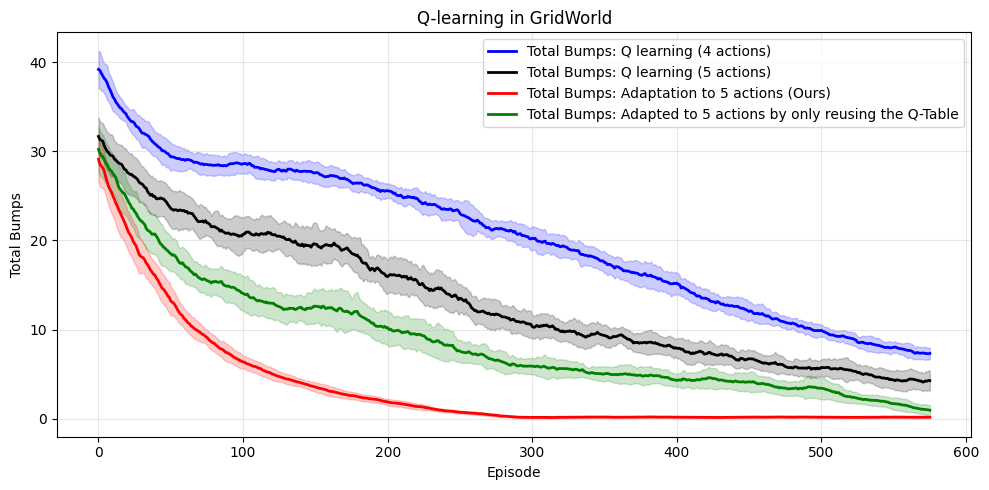

In [11]:
# Required imports for data loading and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import re
from datetime import datetime

def csv_to_stats_format(data):
    """
    Convert CSV data back to the stats format expected by plot_with_shaded_errors
    
    Args:
        data: Dictionary containing loaded CSV dataframes (from load_experimental_data)
    
    Returns:
        Dictionary in the same format as the original stats variable
    """
    if data is None:
        print("Error: No data provided to convert")
        return None
        
    if 'returns' not in data or 'bumps' not in data:
        print("Error: Missing required data (returns and/or bumps)")
        print("Available data keys:", list(data.keys()) if data else "None")
        return None
    
    stats_from_csv = {
        'returns': {},
        'bumps': {}
    }
    
    # Method name mapping
    csv_to_key_mapping = {
        'Q_learning_4_actions': '4_actions',
        'Q_learning_5_actions': '5_plain', 
        'Oracle_method_5_actions': '5_oracle',
        'Q_table_reuse_5_actions': '5_ignore'
    }
    
    # Process returns data
    returns_df = data['returns']
    for csv_method, key in csv_to_key_mapping.items():
        method_data = returns_df[returns_df['Method'] == csv_method]
        if not method_data.empty:
            stats_from_csv['returns'][key] = {
                'mean': method_data['Mean_Return'].values,
                'std': method_data['Std_Return'].values
            }
    
    # Process bumps data
    bumps_df = data['bumps']
    for csv_method, key in csv_to_key_mapping.items():
        method_data = bumps_df[bumps_df['Method'] == csv_method]
        if not method_data.empty:
            stats_from_csv['bumps'][key] = {
                'mean': method_data['Mean_Bumps'].values,
                'std': method_data['Std_Bumps'].values
            }
    
    return stats_from_csv

def plot_with_shaded_errors_from_csv(csv_data_dict, figsize=(10, 5)):
    """
    Plot results with shaded error bars directly from CSV data
    
    Args:
        csv_data_dict: Dictionary containing loaded CSV dataframes
        figsize: Figure size tuple
    """
    # Convert CSV data to stats format
    stats = csv_to_stats_format(csv_data_dict)
    
    # Constants needed for plotting
    episodes_total = 600  # EPISODES constant
    ma_w = 25
    
    # Use the inline plot_with_shaded_errors function
    def plot_with_shaded_errors(stats, figsize=(10, 5)):
        """Plot results with shaded error bars"""
        
        # Returns plot
        plt.figure(figsize=figsize)
        
        # Plot each method with shaded error bars
        methods = [
            ('4_actions', 'Q learning (4 actions)', 'blue'),
            ('5_plain', 'Q learning (5 actions)', 'black'), 
            ('5_oracle', 'Adaptation to 5 actions (Ours)', 'red'),
            ('5_ignore', 'Adapted to 5 actions by only reusing the Q-Table', 'green')
        ]
        
        for method_key, label, color in methods:
            if method_key in stats['returns']:
                mean_vals = stats['returns'][method_key]['mean']
                std_vals = stats['returns'][method_key]['std']
                x_vals = np.arange(episodes_total - len(mean_vals), episodes_total)
                
                # Plot mean line
                plt.plot(x_vals, mean_vals, color=color, label=f'Return: {label}', linewidth=2)
                
                # Plot shaded error region (mean ± std)
                plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                                color=color, alpha=0.2)
        
        plt.xlabel('Episode')
        plt.ylabel('Discounted return')
        plt.title('Q-learning in GridWorld')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Bumps plot
        plt.figure(figsize=figsize)
        
        for method_key, label, color in methods:
            if method_key in stats['bumps']:
                mean_vals = stats['bumps'][method_key]['mean']
                std_vals = stats['bumps'][method_key]['std']
                x_vals = np.arange(len(mean_vals))
                
                # Plot mean line
                plt.plot(x_vals, mean_vals, color=color, label=f'Total Bumps: {label}', linewidth=2)
                
                # Plot shaded error region (mean ± std)
                plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, 
                                color=color, alpha=0.2)
        
        plt.xlabel('Episode')
        plt.ylabel('Total Bumps')
        plt.title('Q-learning in GridWorld')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    plot_with_shaded_errors(stats, figsize=figsize)

def load_experimental_data(results_dir="results", timestamp=None):
    """
    Load experimental data from CSV files
    
    Args:
        results_dir: Directory containing CSV files
        timestamp: Specific timestamp to load (if None, loads most recent)
    
    Returns:
        Dictionary containing all loaded dataframes
    """
    import glob
    import pandas as pd
    import os
    import re
    
    if timestamp:
        pattern = f"{results_dir}/*_{timestamp}.csv"
    else:
        # Find most recent files
        all_csv = glob.glob(f"{results_dir}/*.csv")
        if not all_csv:
            print("No CSV files found!")
            return None
        
        # Extract timestamps and find the most recent
        timestamps = []
        for f in all_csv:
            filename = os.path.basename(f)
            # Look for timestamp pattern: YYYYMMDD_HHMMSS
            timestamp_match = re.search(r'(\d{8}_\d{6})', filename)
            if timestamp_match:
                timestamps.append(timestamp_match.group(1))
        
        if not timestamps:
            print("No properly formatted CSV files found!")
            print("Available files:", [os.path.basename(f) for f in all_csv])
            print("Looking for files with timestamp format: YYYYMMDD_HHMMSS")
            return None
            
        latest_timestamp = max(timestamps)
        print(f"Found latest timestamp: {latest_timestamp}")
        pattern = f"{results_dir}/*_{latest_timestamp}.csv"
    
    files = glob.glob(pattern)
    if not files:
        print(f"No files found matching pattern: {pattern}")
        return None
        
    print(f"Found {len(files)} files with timestamp {latest_timestamp if not timestamp else timestamp}")
    data = {}
    
    for file in files:
        filename = os.path.basename(file)
        try:
            if 'returns_data' in filename:
                data['returns'] = pd.read_csv(file)
                print(f"Loaded returns data: {filename}")
            elif 'bumps_data' in filename:
                data['bumps'] = pd.read_csv(file)
                print(f"Loaded bumps data: {filename}")
            elif 'summary_statistics' in filename:
                data['summary'] = pd.read_csv(file)
                print(f"Loaded summary data: {filename}")
            elif 'experimental_config' in filename:
                data['config'] = pd.read_csv(file)
                print(f"Loaded config data: {filename}")
            elif 'experiment_metadata' in filename:
                data['metadata'] = pd.read_csv(file)
                print(f"Loaded metadata: {filename}")
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    if not data:
        print("No data loaded successfully")
        return None
        
    print(f"Successfully loaded {len(data)} datasets")
    return data
# Test the conversion and plotting with your CSV data
data = load_experimental_data()
if data is not None:
    stats_from_csv = csv_to_stats_format(data)
    if stats_from_csv is not None:
        plot_with_shaded_errors_from_csv(data)
    else:
        print("Failed to convert CSV data to stats format")
else:
    print("Failed to load experimental data")

**2 things to note here: Our method learns faster and better policies than the 4 action case (which is expected) and we encounter fewer unsafe actions both compared to regular Q learning with 5 actions, as well as compared to the original Q learning with 4 actions.**

- present in a table data
- save data to dataFrame
- shaded error bar matplotlib
- plan in future (continuous state space, function approximate, transformer model to predict the next state of new action: https://arxiv.org/abs/2106.01345)
- scaleability of the model, make sure it is still useful when we have more actions: Theory analyze about this 
- update caption and research paper
- Add more lines for  literature review


### Calculate table

In [12]:
# === Mean±Std Table Generator (aligned to example image style) ===
import pandas as pd
from typing import Dict, List, Optional

def generate_mean_std_table(
    results_dir: str = "/Users/thong/Documents/GitHub/AI/SIT723/results",
    timestamp: str = "20250925_045946",
    methods_mapping: Optional[Dict[str, str]] = None,
    decimals: int = 1,
    save_csv: bool = True,
    csv_name: str = "performance_table_mean_std.csv",
):
    """
    Build a table with mean±std for Discounted Return and Total Bumps, aligned by the latest
    common episode per method (fallbacks applied if exact match is missing).

    Returns a DataFrame with formatted strings (e.g., -7.3±0.3) and numeric columns too.
    Also prints Markdown and LaTeX tables you can copy into papers.
    """
    returns_file = f"{results_dir}/returns_data_{timestamp}.csv"
    bumps_file = f"{results_dir}/bumps_data_{timestamp}.csv"

    returns_df = pd.read_csv(returns_file)
    bumps_df = pd.read_csv(bumps_file)

    # Default display names
    if methods_mapping is None:
        methods_mapping = {
            "Q_learning_4_actions": "Q learning (4 actions)",
            "Q_learning_5_actions": "Q learning (5 actions)",
            "Oracle_method_5_actions": "Adaptation to 5 actions (Ours)",
            "Q_table_reuse_5_actions": "Adapted to 5 actions by only reusing the Q-Table",
        }

    # Helper to format mean±std with requested decimals
    def fmt(mean: float, std: float) -> str:
        return f"{mean:.{decimals}f}±{std:.{decimals}f}"

    rows = []

    for method_key, method_display in methods_mapping.items():
        r = returns_df[returns_df["Method"] == method_key].copy()
        b = bumps_df[bumps_df["Method"] == method_key].copy()
        if r.empty and b.empty:
            continue

        # Determine aligned episode: latest common episode if possible
        common_eps = sorted(set(r["Episode"].unique()) & set(b["Episode"].unique())) if (not r.empty and not b.empty) else []
        if common_eps:
            ep = common_eps[-1]
        else:
            # Fallback: choose max episode from returns, else bumps
            ep = None
            if not r.empty:
                ep = int(r["Episode"].max())
            if not b.empty:
                ep_b = int(b["Episode"].max())
                # If returns ep is None or bumps ep is earlier/later, pick the min to stay conservative
                if ep is None:
                    ep = ep_b
                else:
                    ep = min(ep, ep_b)

        # Pull data for that episode; if missing, fallback to last available row
        if not r.empty:
            rr = r[r["Episode"] == ep]
            if rr.empty:
                rr = r.sort_values("Episode").tail(1)
            ret_mean = float(rr["Mean_Return"].iloc[0])
            ret_std = float(rr["Std_Return"].iloc[0])
        else:
            ret_mean, ret_std = float("nan"), float("nan")

        if not b.empty:
            bb = b[b["Episode"] == ep]
            if bb.empty:
                bb = b.sort_values("Episode").tail(1)
            bumps_mean = float(bb["Mean_Bumps"].iloc[0])
            bumps_std = float(bb["Std_Bumps"].iloc[0])
        else:
            bumps_mean, bumps_std = float("nan"), float("nan")

        rows.append({
            "Method": method_display,
            "Episode": ep,
            "Discounted Return (mean±std)": fmt(ret_mean, ret_std),
            "Total Bumps (mean±std)": fmt(bumps_mean, bumps_std),
            "Return_Mean": ret_mean,
            "Return_Std": ret_std,
            "Bumps_Mean": bumps_mean,
            "Bumps_Std": bumps_std,
        })

    table_df = pd.DataFrame(rows)
    table_df.to_csv(f"{results_dir}/{csv_name}", index=False)
    # Pretty print (Markdown)
    print("\nMarkdown table (copy into docs):\n")
    md_header = "| Method | Discounted Return (mean±std) | Total Bumps (mean±std) |\n|---|---:|---:|"
    print(md_header)
    for _, row in table_df.iterrows():
        print(f"| {row['Method']} | {row['Discounted Return (mean±std)']} | {row['Total Bumps (mean±std)']} |")

    # LaTeX table
    print("\nLaTeX table (copy into paper):\n")
    print("\\begin{tabular}{lrr}")
    print("\\toprule")
    print("Method & Discounted Return & Total Bumps \\")
    print("\\midrule")
    for _, row in table_df.iterrows():
        print(f"{row['Method']} & {row['Discounted Return (mean±std)']} & {row['Total Bumps (mean±std)']} \\")
    print("\\bottomrule")
    print("\\end{tabular}")

    if save_csv:
        out_path = f"{results_dir}/{csv_name}"
        table_df.to_csv(out_path, index=False)
        print(f"\nSaved CSV: {out_path}")

    return table_df

# Run the generator with existing results
mean_std_table = generate_mean_std_table()


Markdown table (copy into docs):

| Method | Discounted Return (mean±std) | Total Bumps (mean±std) |
|---|---:|---:|
| Q learning (4 actions) | -7.7±0.3 | 7.3±0.6 |
| Q learning (5 actions) | -4.0±0.5 | 4.3±1.1 |
| Adaptation to 5 actions (Ours) | -1.7±0.0 | 0.2±0.1 |
| Adapted to 5 actions by only reusing the Q-Table | -2.6±0.4 | 1.0±0.6 |

LaTeX table (copy into paper):

\begin{tabular}{lrr}
\toprule
Method & Discounted Return & Total Bumps \
\midrule
Q learning (4 actions) & -7.7±0.3 & 7.3±0.6 \
Q learning (5 actions) & -4.0±0.5 & 4.3±1.1 \
Adaptation to 5 actions (Ours) & -1.7±0.0 & 0.2±0.1 \
Adapted to 5 actions by only reusing the Q-Table & -2.6±0.4 & 1.0±0.6 \
\bottomrule
\end{tabular}

Saved CSV: /Users/thong/Documents/GitHub/AI/SIT723/results/performance_table_mean_std.csv
